In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import xgboost as xgb
from statsmodels.stats.anova import anova_lm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.gam.api import GLMGam, BSplines


# import diagnostics from smlearn website
import SM_plots as SM

warnings.filterwarnings('ignore')

In [2]:
# load data
path = '/Users/dylanjorling/UCLA/412proj/data/'
name = 'full_combine_data'
data = pd.read_csv(path + name, index_col=0)
data.shape

(13210, 15)

In [3]:
################## EDA Plots ##################
combine_complete = data.dropna()
print(combine_complete.shape)
combine_complete.head()
combine_complete = combine_complete[combine_complete['pick'] != 'undrafted']
#combine_complete = combine_complete[combine_complete['pos'] == 'LB'] #filter for specific positions
#combine_complete = combine_complete[combine_complete['year'] >= 2010] #filter for specific year...didn't alter much
combine_complete['pick'] = combine_complete['pick'].astype(int)
combine_complete = combine_complete[combine_complete['pick'] < 300]
combine_complete = combine_complete[combine_complete['bench'] < 74]
pos_one_hot = combine_complete['pos'].str.get_dummies()


y = combine_complete['pick']
X = combine_complete.iloc[:, 4:-1]
X = pd.concat([X, pos_one_hot], axis=1)
null_sd = y.std()
print(null_sd)

combine_complete.head()

(5843, 15)
69.80294730041324


,year,name,college,pos,height,weight,hand_size,arm_length,forty,bench,vert,broad_jump,shuttle,3cone,pick
3350,1997,John Allred,USC,TE,76.4,244,10.00,32.50,5.01,15.0,32.0,112.0,4.32,7.45,38
3355,1997,Duane Ashman,Virginia,DE,75.5,274,9.50,35.63,5.03,19.0,32.5,110.0,4.83,8.80,161
3357,1997,Raymond Austin,Tennessee,DB,70.6,190,10.25,32.00,4.80,12.0,32.5,111.0,4.05,7.14,145
3360,1997,Antonio Banks,Virginia Tech,DB,70.0,203,9.50,32.00,4.66,18.0,36.0,117.0,4.41,7.85,113
3361,1997,Ronde Barber,Virginia,DB,69.4,185,9.50,31.63,4.68,14.0,34.5,118.0,4.46,7.22,66


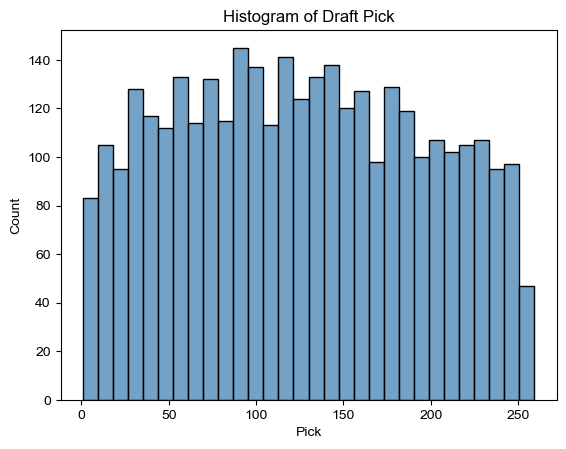

In [5]:
ax = sns.histplot(combine_complete, x='pick', color="steelblue", bins=30)
ax.set(xlabel='Pick', ylabel='Count', title='Histogram of Draft Pick')
sns.set_style("whitegrid")
plt.show()
# underlying distribution is uniform

In [6]:
pos_means = combine_complete.groupby('pos').mean()['pick']
ax = sns.boxplot(data=combine_completex=pos_means, y=pos_means.index, orient='h')
ax.set(xlabel='Pick', ylabel='Position', title='Average Pick by Position')
sns.set_style("whitegrid")
plt.show()

SyntaxError: invalid syntax (2923876736.py, line 2)

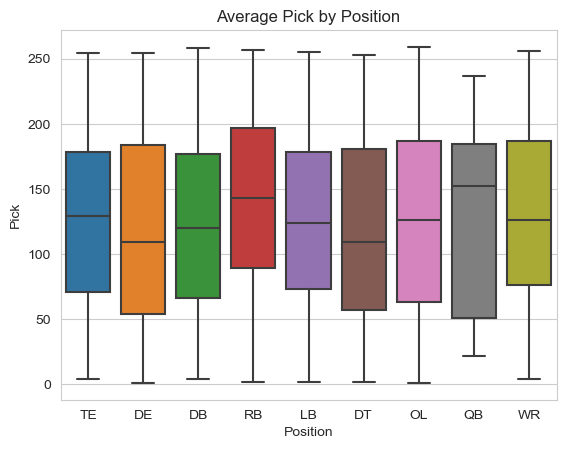

In [7]:
pos_means = combine_complete.groupby('pos').mean()['pick']
ax = sns.boxplot(data=combine_complete, x='pos', y='pick')
ax.set(xlabel='Position', ylabel='Pick', title='Average Pick by Position')
sns.set_style("whitegrid")
plt.show()

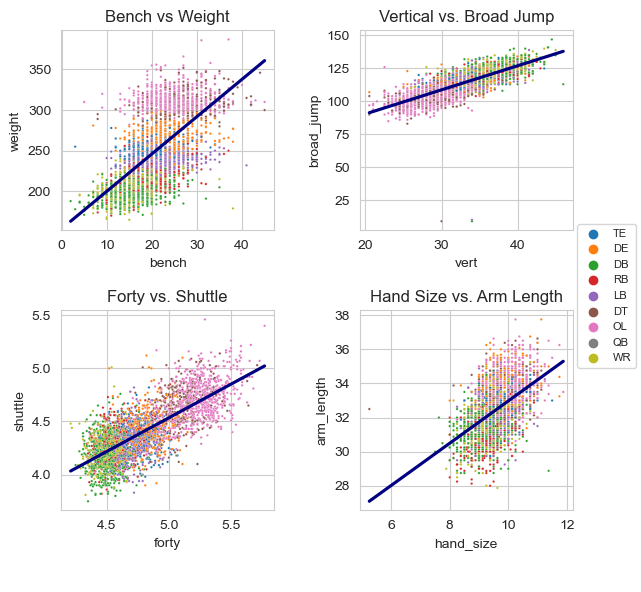

In [101]:
# This is a plot of some of the more predictive variables

fig, axs = plt.subplots(nrows=2, ncols=2)
sns.scatterplot(data=combine_complete,
                x='bench',
                y='weight',
                hue='pos',
                s=3,
                ax=axs[0,0],
               legend=False)
axs[0, 0].set(xlabel='Bench Press Reps', ylabel='Weight', title='Bench vs Weight')
sns.regplot(data=combine_complete,
            x='bench',
            y='weight',
            scatter=False,
            ci=None,
            color="navy",
            ax=axs[0,0])
sns.set_style("whitegrid")

sns.scatterplot(data=combine_complete,
                x='vert',
                y='broad_jump',
                hue='pos',
                s=3,
                ax=axs[0,1],
               legend=False)
axs[0, 1].set(xlabel='Vert', ylabel='Broad Jump', title='Vertical vs. Broad Jump')
sns.regplot(data=combine_complete,
            x='vert',
            y='broad_jump',
            scatter=False,
            ci=None,
            color="navy",
            ax=axs[0,1])
sns.set_style("whitegrid")

sns.scatterplot(data=combine_complete,
                x='forty',
                y='shuttle',
                hue='pos',
                s=3,
                ax=axs[1,0],
               legend=False)
axs[1, 0].set(xlabel='Forty', ylabel='Shuttle', title='Forty vs. Shuttle')
sns.regplot(data=combine_complete,
            x='forty',
            y='shuttle',
            scatter=False,
            ci=None,
            color="navy",
            ax=axs[1,0])
sns.set_style("whitegrid")

sns.scatterplot(data=combine_complete,
                x='hand_size',
                y='arm_length',
                hue='pos',
                s=3,
                ax=axs[1,1],
               legend=False)
axs[1, 1].set(xlabel='Hand Size', ylabel='Arm Length', title='Hand Size vs. Arm Length')

sns.regplot(data=combine_complete,
            x='hand_size',
            y='arm_length',
            scatter=False,
            ci=None,
            color="navy",
            ax=axs[1,1])
sns.set_style("whitegrid")

#handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center right', fontsize = 8)
plt.gca().get_legend_handles_labels()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=1.5,
                    wspace=0.4,
                    hspace=0.4)
fig.show()

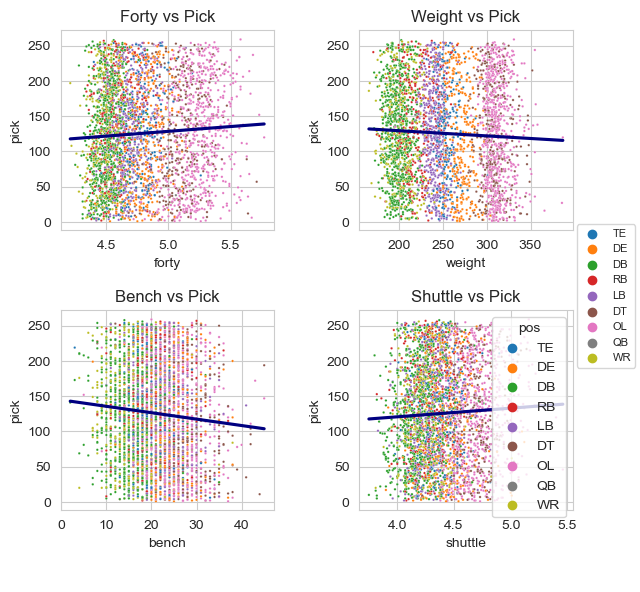

In [94]:
# This is a plot of some of the more predictive variables

fig, axs = plt.subplots(nrows=2, ncols=2)
sns.scatterplot(data=combine_complete,
                x='forty',
                y='pick',
                hue='pos',
                s=3,
                ax=axs[0,0],
               legend=False)
axs[0, 0].set(xlabel='forty yard dash time', ylabel='Pick', title='Forty vs Pick')
sns.regplot(data=combine_complete,
            x='forty',
            y='pick',
            scatter=False,
            ci=None,
            color="navy",
            ax=axs[0,0])
sns.set_style("whitegrid")

sns.scatterplot(data=combine_complete,
                x='weight',
                y='pick',
                hue='pos',
                s=3,
                ax=axs[0,1],
               legend=False)
axs[0, 1].set(xlabel='weight', ylabel='Pick', title='Weight vs Pick')
sns.regplot(data=combine_complete,
            x='weight',
            y='pick',
            scatter=False,
            ci=None,
            color="navy",
            ax=axs[0,1])
sns.set_style("whitegrid")

sns.scatterplot(data=combine_complete,
                x='bench',
                y='pick',
                hue='pos',
                s=3,
                ax=axs[1,0],
               legend=False)
axs[1, 0].set(xlabel='bench press reps', ylabel='Pick', title='Bench vs Pick')
sns.regplot(data=combine_complete,
            x='bench',
            y='pick',
            scatter=False,
            ci=None,
            color="navy",
            ax=axs[1,0])
sns.set_style("whitegrid")

sns.scatterplot(data=combine_complete,
                x='shuttle',
                y='pick',
                hue='pos',
                s=3,
                ax=axs[1,1],
               legend=True)
axs[1, 1].set(xlabel='shuttle time', ylabel='Pick', title='Shuttle vs Pick')

sns.regplot(data=combine_complete,
            x='shuttle',
            y='pick',
            scatter=False,
            ci=None,
            color="navy",
            ax=axs[1,1])
sns.set_style("whitegrid")

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center right', fontsize = 8)
plt.gca().get_legend_handles_labels()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=1.5,
                    wspace=0.4,
                    hspace=0.4)
fig.show()


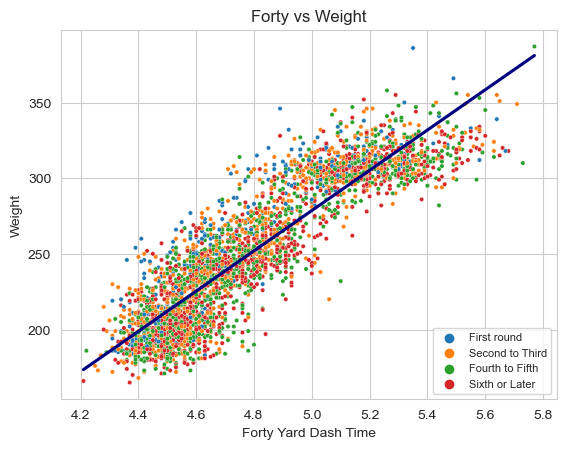

In [46]:
# This is weight v forty time binned by pick intervals
combine_round_est = combine_complete
combine_round_est['Estimated Round'] = pd.cut(
    combine_round_est['pick'],
    bins=[0, 32, 100, 175, 350],
    labels=['First round', 'Second to Third',
            'Fourth to Fifth', 'Sixth or Later'])

ax = sns.scatterplot(data=combine_round_est,
                      x='forty',
                      y='weight',
                      hue='Estimated Round',
                      s=10)
sns.regplot(data=combine_round_est,
            x='forty',
            y='weight',
            scatter=False,
            ci=None,
            color="navy",
            ax=ax)

ax.set(xlabel='Forty Yard Dash Time', ylabel='Weight', title='Forty vs Weight')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower right', fontsize = 8)
sns.set_style("whitegrid")
plt.show()

In [47]:
################## Linear Model w/ model selection ##################
# set up basic linear model with complete cases and to simplify further, filter out undrafted players
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                   pick   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     18.31
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           3.50e-56
Time:                        23:27:12   Log-Likelihood:                -19203.
No. Observations:                3418   AIC:                         3.844e+04
Df Residuals:                    3399   BIC:                         3.856e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -233.3898     74.944     -3.114      0.0

In [95]:
# Backward Elimination to select best model
y = combine_complete['pick']
X = combine_complete.iloc[:, 4:-1]
X = pd.concat([X, pos_one_hot], axis=1)
cols = X.columns

for var in cols:
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    p_values = pd.Series(results.pvalues, name='pvalues')
    max_p = p_values[p_values==p_values.max()]
    if max_p[0] > 0.05:
        drop_col = max_p.index[0]
        X = X.drop(columns=drop_col)
    else:
        print(results.summary())
        break
    


                            OLS Regression Results                            
Dep. Variable:                   pick   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     39.27
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           2.81e-60
Time:                        07:25:40   Log-Likelihood:                -19210.
No. Observations:                3418   AIC:                         3.844e+04
Df Residuals:                    3409   BIC:                         3.849e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -222.0558     49.765     -4.462      0.0

In [143]:
ols = SM.Linear_Reg_Diagnostic(results)

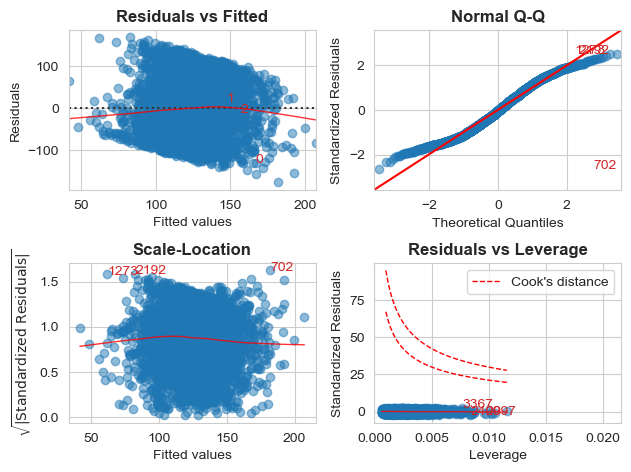

In [156]:
fig, axs = plt.subplots(nrows=2, ncols=2)

ols.residual_plot(ax=axs[0,0])
ols.qq_plot(ax=axs[0,1])
ols.scale_location_plot(ax=axs[1,0])
ols.leverage_plot(ax=axs[1,1])

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
### Try robust ###



In [96]:
################## Linear Model ##################
# will use the model generated from backward selection above
y = combine_complete['pick']
X = combine_complete.iloc[:, 4:-1]
X = pd.concat([X, pos_one_hot], axis=1)
X = X[['weight', 'arm_length','forty', 'bench', 'shuttle', 'DB', 'DT', 'OL']]

cv = KFold(n_splits=3, shuffle=True, random_state=100)
reg = LinearRegression()
scores = cross_val_score(reg, X, y, scoring='neg_mean_squared_error', cv=cv)
rmse = (scores.mean()*-1)**0.5

print(rmse)

67.01796200690795


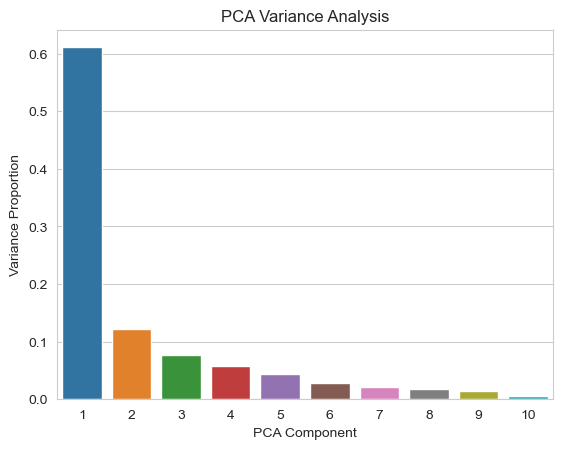

In [8]:
################## Predictive PCA/PCR ##################
y = combine_complete['pick']
X = combine_complete.iloc[:, 4:-1] # do not include posiiton for PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train.values)
pcr = PCA()
pcr.fit(X_train_norm)
#transformed = model.transform(X)
features = range(pcr.n_components_)



ax = sns.barplot(x=pd.Series(features)+1, y=pd.Series(pcr.explained_variance_) / pcr.explained_variance_.sum())
ax.set(xlabel='PCA Component', ylabel='Variance Proportion', title='PCA Variance Analysis')
sns.set_style("whitegrid")
plt.show()


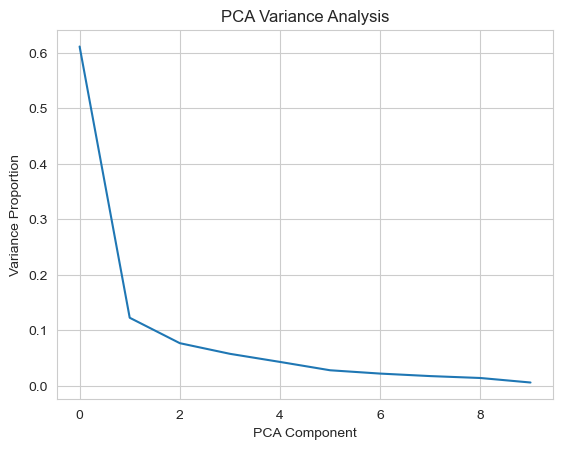

In [130]:
# plot pca vs share of variance:
var_prop = pcr.explained_variance_ / pcr.explained_variance_.sum()
ax = sns.lineplot(x=pd.Series(features), y=pd.Series(var_prop))
ax.set(xlabel='PCA Component', ylabel='Variance Proportion', title='PCA Variance Analysis')
sns.set_style("whitegrid")
plt.show()

# data shows we should use between 2 and 4 PCs so will use 3 here

In [131]:
pca = PCA(n_components=3)
X_train_norm = scaler.fit_transform(X_train.values)
pca.fit_transform(X_train_norm)
linear = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=X.columns)
linear

#PC1 is generally a size metric, PC2 relates to small hands and short arms, PC3 it almost purely strength

,PC1,PC2,PC3
height,0.304736,-0.405880,-0.107401
weight,0.385545,-0.038562,0.142756
hand_size,0.228303,-0.461385,0.002039
arm_length,0.263038,-0.533021,-0.253794
forty,0.373551,0.149111,-0.022600
bench,0.232707,-0.048905,0.913638
vert,-0.319665,-0.333223,0.195778
broad_jump,-0.324417,-0.386599,0.068543
shuttle,0.342782,0.121846,-0.135350
3cone,0.344318,0.191882,-0.084137


In [133]:
# Cross-Validated PC Regression
# scale the test set
pca = PCA(n_components=3)
X_norm = scaler.fit_transform(X.values)

# dim reduce X
X_pca = pca.fit_transform(X_norm)
add_pos = pos_one_hot[['DB', 'DT', 'OL']].values
X_pca2 = np.concatenate([X_pca, add_pos], axis=1)
cv = KFold(n_splits=3, shuffle=True, random_state=100)
reg = LinearRegression()

scores = cross_val_score(reg, X_pca2, y, scoring='neg_mean_squared_error', cv=cv)
rmse = (scores.mean()*-1)**0.5

print(rmse)


68.05924969610729


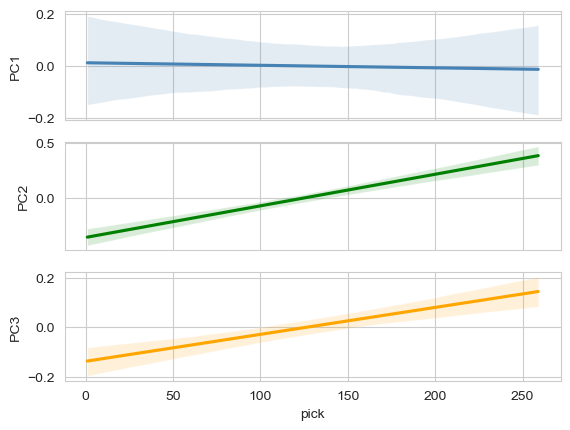

In [134]:
# PC scatterplot vs reponse
df_pca = np.concatenate([X_pca, y.values.reshape(-1,1)], axis=1)
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3', 'pick'])

fig, axs = plt.subplots(nrows=3, sharex=True)
sns.regplot(x='pick', y='PC1', data=df_pca, scatter=False, ax=axs[0], color="steelblue")
axs[0].set_xlabel('')
sns.regplot(x='pick', y='PC2', data=df_pca,scatter=False, ax=axs[1], color="green")
axs[1].set_xlabel('')
sns.regplot(x='pick', y='PC3', data=df_pca, scatter=False, ax=axs[2], color="orange")
sns.set_style("whitegrid")
fig.show()

# note how pc1 has little relationship w y and therefore poor mse

In [86]:
################## XG Boost ##################
y = combine_complete['pick']
X = combine_complete.iloc[:, 4:-1]
X = pd.concat([X, pos_one_hot], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)



n = 1000
max_depth = 1
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                           n_estimators=n, 
                           max_depth=max_depth,
                           eta=0.01,
                           seed=100)

xgb_reg.fit(X_train_norm, y_train)
preds = xgb_reg.predict(X_test_norm)

rmse = mean_squared_error(preds, y_test, squared=False)
print(rmse)

69.51252126008916


In [8]:
# Tune hyperparams w/ gridsearch
param_grid = {
    'max_depth': [1, 2, 3],
    'eta': [0.001, 0.01, 0.1, 0.25, 0.5],
    'n_estimators': [100, 500, 1000],
}
grid_mse = GridSearchCV(estimator=xgb_reg,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        cv=3,
                        verbose=1)
mse_grid = grid_mse.fit(X_norm, y)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


In [28]:
best_params = grid_mse.best_params_
rmse = np.abs(grid_mse.best_score_)**0.5

print(best_params)
print(rmse)

{'eta': 0.25, 'max_depth': 1, 'n_estimators': 100}
68.45412247241667


In [29]:
xgb_final = xgb.XGBRegressor(objective='reg:squarederror',
                           n_estimators=100, 
                           max_depth=1,
                           eta=0.25,
                           seed=100)
xgb_final.fit(X_norm, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.25, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

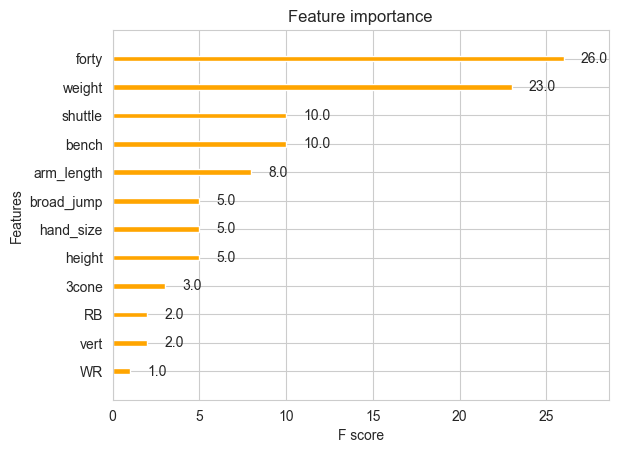

In [90]:
# plot feature importance
feature_names = X.columns

ax = xgb.plot_importance(xgb_final, color="orange")
ylabs = list(ax.get_yticklabels())
dict_features = dict(enumerate(feature_names))
ylabs_stripped = [ylabs[i].get_text().lstrip('f') for i in range(len(ylabs))]
ylabs_stripped = [dict_features[int(i)] for i in ylabs_stripped]

ax.set_yticklabels(ylabs_stripped)
plt.show()

In [ ]:
################## Final Cross-Validated RMSE ##################
# Linear: 67.14958397888446
# PCR: 68.68564523905418
# XGBoost: 68.45412247241667